## Project 3

**Dataset(s) to be used:**

1. Daily Bitcoin price data (BTC-USD) from Yahoo Finance, downloaded via `yfinance` and saved locally as `bitcoin_daily.csv`.  
2. Daily S&P 500 index price data (^GSPC) from Yahoo Finance, downloaded via `yfinance` and saved locally as `sp500_daily.csv`.  

(Original sources:  
- BTC-USD: https://finance.yahoo.com/quote/BTC-USD/history  
- ^GSPC: https://finance.yahoo.com/quote/%5EGSPC/history)

---

**Analysis question:**

Has Bitcoin become increasingly correlated with the U.S. stock market (S&P 500 index) over time between 2015 and 2025?

---

**Columns that will likely be used:**

From the Bitcoin dataset (`bitcoin_daily.csv`):
- `Price` (to be renamed `Date`)
- `Close` (to be renamed `btc_close`)
- `High` (for descriptive stats)
- `Low` (for descriptive stats)
- `Open` (for descriptive stats)
- `Volume` (to be renamed `btc_volume`)

From the S&P 500 dataset (`sp500_daily.csv`):
- `Price` (to be renamed `Date`)
- `Close` (to be renamed `sp_close`)
- `High` 
- `Low` 
- `Open`
- `Volume` (to be renamed `sp_volume`)

Computed columns (created in the notebook):
- `btc_ret`: daily percentage returns for Bitcoin
- `sp_ret`: daily percentage returns for the S&P 500
- `corr_90d`: 90-day rolling correlation between `btc_ret` and `sp_ret`
- `corr_180d`, `corr_365d` for longer windows

---

**Columns to be used to merge/join them:**

- Bitcoin dataset: `Date` (renamed from `Price`)
- S&P 500 dataset: `Date` (renamed from `Price`)

We will merge on `Date` using an inner join so that only days where we have both BTC and S&P 500 data are included.

---

**Hypothesis:**

Bitcoin’s correlation with the S&P 500 has increased significantly over time, especially after 2018. In earlier years, Bitcoin behaved more like an uncorrelated or weakly correlated asset, but from around 2018–2025 it increasingly moves together with the S&P 500, suggesting that Bitcoin is becoming more “financialized” and behaving like a mainstream risk asset rather than a purely independent store of value.



In [3]:
# ensure the visualizations render properly across VSCode, Jupyter Book, etc.
# https://plotly.com/python/renderers/

import plotly.io as pio

pio.renderers.default = "notebook_connected+plotly_mimetype"

### Loading and Saving the Raw Data

To make the project fully reproducible and independent of a live internet connection, I first use the `yfinance` library to download daily price data directly from Yahoo Finance. I pull two datasets:

1. Bitcoin (BTC-USD), and  
2. The S&P 500 index (^GSPC).

After downloading, I save each dataset as a local CSV file (`bitcoin_daily.csv` and `sp500_daily.csv`). This ensures that the rest of the analysis can be run later using only local files, without calling the API again.

In [4]:
import yfinance as yf

btc = yf.download("BTC-USD", start="2015-01-01")
btc.to_csv("bitcoin_daily.csv")

/var/folders/4r/82c5nm0x3gqd56z9s4z1125m0000gn/T/ipykernel_99703/1175749813.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [5]:
import yfinance as yf

sp500 = yf.download("^GSPC", start="2015-01-01")
sp500.to_csv("sp500_daily.csv")


/var/folders/4r/82c5nm0x3gqd56z9s4z1125m0000gn/T/ipykernel_99703/548379730.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


### Inspecting the Raw CSV Structure

Next, I load both CSV files into pandas DataFrames to inspect their raw structure. This initial inspection helps me understand how the data is stored (column names, types, and any extra header rows) before I start cleaning.

In particular, I want to verify that:
- the date column is present,
- price columns are correctly labeled, and
- there are no unexpected extra rows or metadata at the top of the file.

In [6]:
import pandas as pd

btc = pd.read_csv("bitcoin_daily.csv")
sp = pd.read_csv("sp500_daily.csv")

print("BTC columns:", btc.columns.tolist())
print("SP500 columns:", sp.columns.tolist())

btc.head(), sp.head()


BTC columns: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
SP500 columns: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']


(        Price              Close                High                 Low  \
 0      Ticker            BTC-USD             BTC-USD             BTC-USD   
 1        Date                NaN                 NaN                 NaN   
 2  2015-01-01  314.2489929199219  320.43499755859375  314.00299072265625   
 3  2015-01-02  315.0320129394531   315.8389892578125  313.56500244140625   
 4  2015-01-03  281.0820007324219   315.1499938964844   281.0820007324219   
 
                  Open    Volume  
 0             BTC-USD   BTC-USD  
 1                 NaN       NaN  
 2  320.43499755859375   8036550  
 3   314.0790100097656   7860650  
 4  314.84600830078125  33054400  ,
         Price               Close               High                 Low  \
 0      Ticker               ^GSPC              ^GSPC               ^GSPC   
 1        Date                 NaN                NaN                 NaN   
 2  2015-01-02   2058.199951171875  2072.360107421875     2046.0400390625   
 3  2015-01-05  2

### Reloading the Data and Skipping Extra Header Rows

Because the initial CSV inspection shows two non-data rows at the top (containing ticker labels and an extra header row), I reload both files using `skiprows=2`. This drops those first two rows and leaves me with a clean tabular format where each row represents a single trading day.

I then print the column names and the first few rows again to confirm that the data now starts at the actual first observation in 2015.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load CSVs and skip the extra header rows ---

btc = pd.read_csv("bitcoin_daily.csv", skiprows=2)
sp = pd.read_csv("sp500_daily.csv", skiprows=2)

print("BTC columns:", btc.columns.tolist())
print("SP500 columns:", sp.columns.tolist())

btc.head(), sp.head()


BTC columns: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
SP500 columns: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']


(         Date  Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5
 0  2015-01-01  314.248993  320.434998  314.002991  320.434998     8036550
 1  2015-01-02  315.032013  315.838989  313.565002  314.079010     7860650
 2  2015-01-03  281.082001  315.149994  281.082001  314.846008    33054400
 3  2015-01-04  264.195007  287.230011  257.612000  281.145996    55629100
 4  2015-01-05  274.473999  278.341003  265.084015  265.084015    43962800,
          Date   Unnamed: 1   Unnamed: 2   Unnamed: 3   Unnamed: 4  Unnamed: 5
 0  2015-01-02  2058.199951  2072.360107  2046.040039  2058.899902  2708700000
 1  2015-01-05  2020.579956  2054.439941  2017.339966  2054.439941  3799120000
 2  2015-01-06  2002.609985  2030.250000  1992.439941  2022.150024  4460110000
 3  2015-01-07  2025.900024  2029.609985  2005.550049  2005.550049  3805480000
 4  2015-01-08  2062.139893  2064.080078  2030.609985  2030.609985  3934010000)

### Renaming Columns and Parsing Dates

After skipping the extra header rows, the price and volume columns are still labeled as `Unnamed: 1`, `Unnamed: 2`, etc. To make the analysis more readable and less error-prone, I rename these columns to meaningful names:

- For Bitcoin: `btc_open`, `btc_high`, `btc_low`, `btc_close`, `btc_volume`  
- For the S&P 500: `sp_open`, `sp_high`, `sp_low`, `sp_close`, `sp_volume`

I also convert the `Date` column to a proper datetime type and sort each DataFrame by date. This ensures that any time-series operations (like computing returns and rolling correlations) will be applied in strict chronological order.


In [8]:
# --- Rename columns properly for BTC ---
btc = btc.rename(columns={
    'Unnamed: 1': 'btc_open',
    'Unnamed: 2': 'btc_high',
    'Unnamed: 3': 'btc_low',
    'Unnamed: 4': 'btc_close',
    'Unnamed: 5': 'btc_volume'
})

# --- Rename columns properly for SP500 ---
sp = sp.rename(columns={
    'Unnamed: 1': 'sp_open',
    'Unnamed: 2': 'sp_high',
    'Unnamed: 3': 'sp_low',
    'Unnamed: 4': 'sp_close',
    'Unnamed: 5': 'sp_volume'
})

# --- Convert Date to datetime ---
btc['Date'] = pd.to_datetime(btc['Date'])
sp['Date'] = pd.to_datetime(sp['Date'])

# --- Sort by date ---
btc = btc.sort_values("Date")
sp = sp.sort_values("Date")



In [9]:
btc.head()

,Date,btc_open,btc_high,btc_low,btc_close,btc_volume
0,2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
1,2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2,2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
3,2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
4,2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800


In [10]:
sp.head()

,Date,sp_open,sp_high,sp_low,sp_close,sp_volume
0,2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
1,2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2,2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
3,2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
4,2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000


### Computing Daily Returns

Financial correlations are usually computed on **returns**, not on raw price levels. Prices are non-stationary and can trend over time, which can distort correlation estimates. To address this, I compute daily percentage returns for both assets using `pct_change()` on the closing price:

- `btc_ret` = daily percentage return of Bitcoin  
- `sp_ret` = daily percentage return of the S&P 500

These return series will be the basis for all correlation calculations in the rest of the project.


In [11]:
# Compute daily returns for BTC and SP500

btc['btc_ret'] = btc['btc_close'].pct_change()
sp['sp_ret'] = sp['sp_close'].pct_change()

In [12]:

btc[['Date', 'btc_close', 'btc_ret']].head()

,Date,btc_close,btc_ret
0,2015-01-01,320.434998,NaN
1,2015-01-02,314.079010,-0.019835
2,2015-01-03,314.846008,0.002442
3,2015-01-04,281.145996,-0.107036
4,2015-01-05,265.084015,-0.057130


In [13]:
sp[['Date', 'sp_close', 'sp_ret']].head()

,Date,sp_close,sp_ret
0,2015-01-02,2058.899902,NaN
1,2015-01-05,2054.439941,-0.002166
2,2015-01-06,2022.150024,-0.015717
3,2015-01-07,2005.550049,-0.008209
4,2015-01-08,2030.609985,0.012495


### Merging Bitcoin and S&P 500 Returns on Date

To study how Bitcoin and the S&P 500 move together, I need both return series aligned on the same calendar. I merge the two DataFrames on the `Date` column using an inner join. This keeps only the dates where **both** BTC and the S&P 500 have valid data.

After merging, I drop any remaining rows with `NaN` values in either return series. The resulting DataFrame `df` contains one row per trading day with:

- `btc_ret`: Bitcoin daily return  
- `sp_ret`: S&P 500 daily return  

This is the dataset used for the rolling correlation analysis.


In [14]:
# Merge BTC and SP returns on Date

df = pd.merge(
    btc[['Date', 'btc_ret']],
    sp[['Date', 'sp_ret']],
    on='Date',
    how='inner'   # keep only dates present in BOTH
)

print(df.shape)
df = df.dropna()
df.head()


(2748, 3)


,Date,btc_ret,sp_ret
1,2015-01-05,-0.057130,-0.002166
2,2015-01-06,0.035939,-0.015717
3,2015-01-07,0.041754,-0.008209
4,2015-01-08,0.028167,0.012495
5,2015-01-09,-0.039954,0.016172


### Rolling Correlation Windows

To examine how the relationship between Bitcoin and the S&P 500 evolves over time, I compute rolling correlations between their daily returns. Instead of a single correlation number for the entire 2015–2025 period, rolling windows show how correlation changes across the sample.

I use three window lengths:

- 90-day rolling correlation (`corr_90d`): roughly a quarter of trading days (short-term behavior)  
- 180-day rolling correlation (`corr_180d`): medium-term behavior  
- 365-day rolling correlation (`corr_365d`): long-term trend

For each window, the correlation is computed between `btc_ret` and `sp_ret` using the last *N* days of data.


In [15]:
# Compute Rolling Correlation

# 90-day rolling correlation
df['corr_90d'] = df['btc_ret'].rolling(window=90).corr(df['sp_ret'])

# Optional additional windows
df['corr_180d'] = df['btc_ret'].rolling(window=180).corr(df['sp_ret'])
df['corr_365d'] = df['btc_ret'].rolling(window=365).corr(df['sp_ret'])

df.head(10)


,Date,btc_ret,sp_ret,corr_90d,corr_180d,corr_365d
1,2015-01-05,-0.057130,-0.002166,NaN,NaN,NaN
2,2015-01-06,0.035939,-0.015717,NaN,NaN,NaN
3,2015-01-07,0.041754,-0.008209,NaN,NaN,NaN
4,2015-01-08,0.028167,0.012495,NaN,NaN,NaN
5,2015-01-09,-0.039954,0.016172,NaN,NaN,NaN
6,2015-01-12,-0.030815,-0.008394,NaN,NaN,NaN
7,2015-01-13,0.004689,-0.007111,NaN,NaN,NaN
8,2015-01-14,-0.162681,-0.006488,NaN,NaN,NaN
9,2015-01-15,-0.209907,-0.002304,NaN,NaN,NaN
10,2015-01-16,0.181874,-0.010677,NaN,NaN,NaN


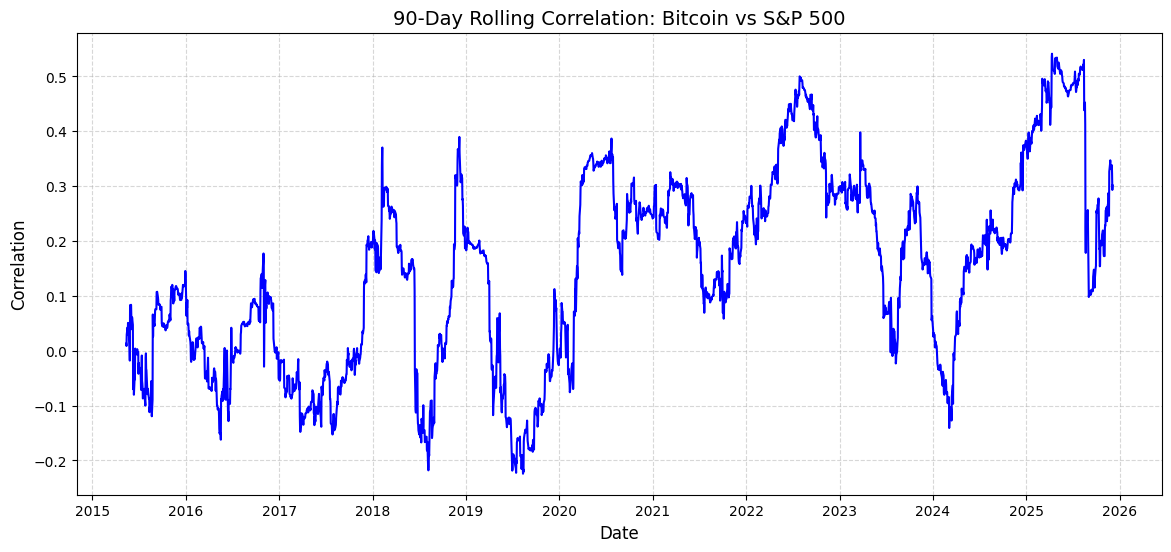

In [16]:
# Plot Rolling Correlation
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['corr_90d'], color='blue')

plt.title("90-Day Rolling Correlation: Bitcoin vs S&P 500", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



**Figure 1 – 90-Day Rolling Correlation**

This figure shows the 90-day rolling correlation between Bitcoin and the S&P 500. Early in the sample (roughly 2015–2017), the correlation fluctuates around zero and is sometimes even negative, indicating that the two assets often moved independently or in opposite directions over short horizons. Starting around 2018, the 90-day correlation becomes more consistently positive and reaches higher peaks, especially around major market events such as the COVID-19 shock in 2020. This suggests that, over short-term windows, Bitcoin begins to behave more like a typical risk asset that often moves in tandem with the stock market.


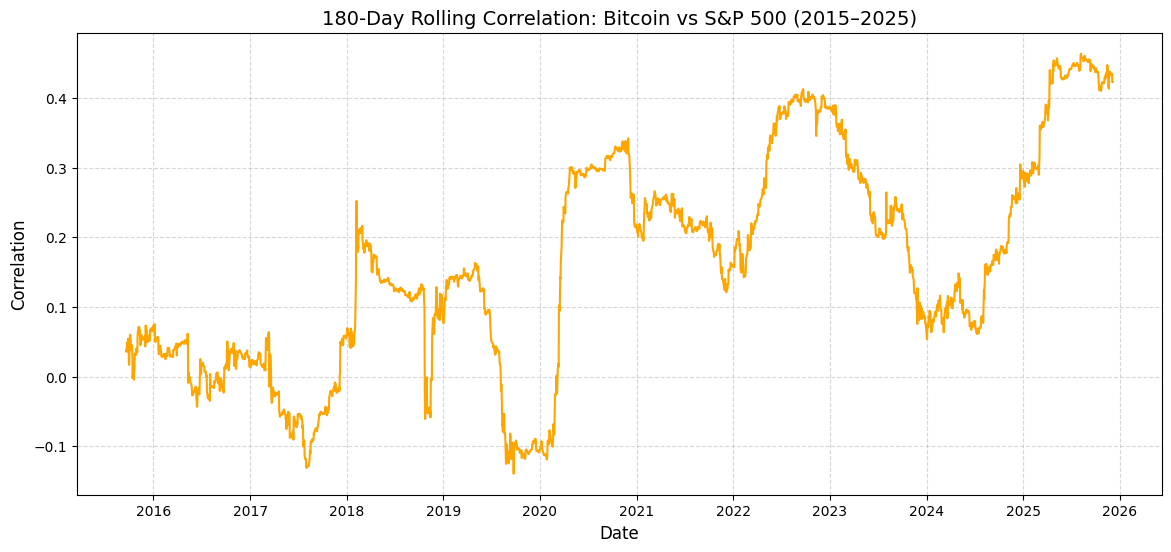

In [17]:
# 180-Day Rolling Correlation Plot

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['corr_180d'], color='orange')

plt.title("180-Day Rolling Correlation: Bitcoin vs S&P 500 (2015–2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Correlation", fontsize=12)
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

**Figure 2 – 180-Day Rolling Correlation**

This figure plots the 180-day rolling correlation, which smooths out some of the short-term volatility seen in the 90-day window. The longer window makes it easier to see the medium-term trend: correlation is low and unstable before 2018, but gradually rises and stays more consistently positive afterward. The 180-day series highlights that the periods of high short-term correlation around 2020–2022 are not just brief spikes—they contribute to a sustained medium-run increase in co-movement between Bitcoin and the S&P 500.


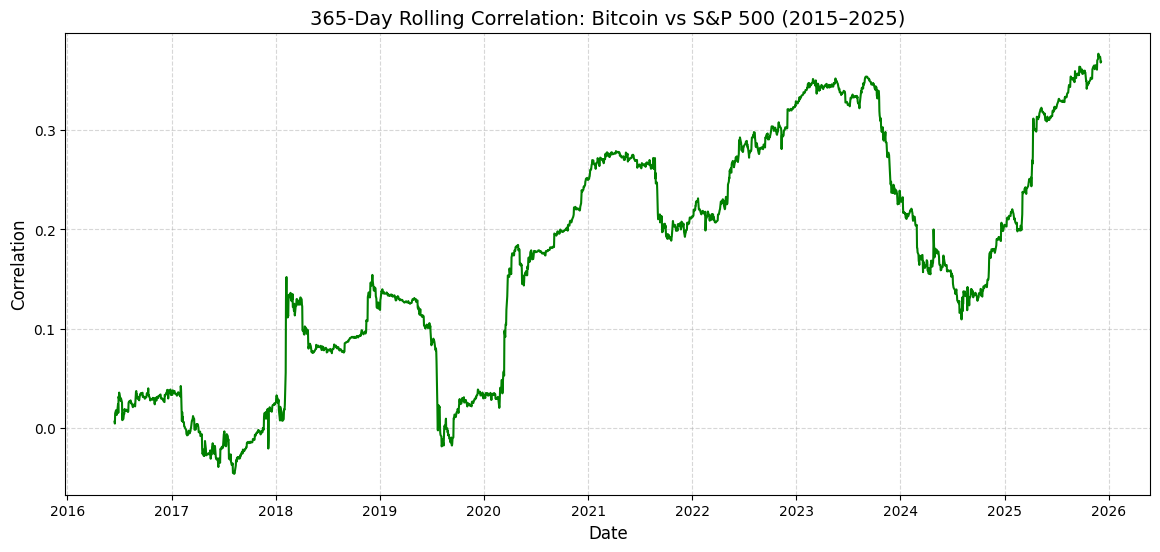

In [18]:
# 365-Day Rolling Correlation Plot

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['corr_365d'], color='green')

plt.title("365-Day Rolling Correlation: Bitcoin vs S&P 500 (2015–2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


**Figure 3 – 365-Day Rolling Correlation**

The 365-day rolling correlation focuses on the long-run relationship between Bitcoin and the S&P 500 by averaging over approximately one calendar year of returns at each point in time. Early in the sample, the 365-day correlation remains close to zero, consistent with the idea that Bitcoin was initially weakly tied to traditional equity markets. Over time, especially after 2018 and into the early 2020s, the 365-day correlation drifts upward and stabilizes in positive territory. This long-run pattern suggests a structural shift: Bitcoin becomes increasingly integrated into broader market dynamics rather than behaving as a completely independent asset.


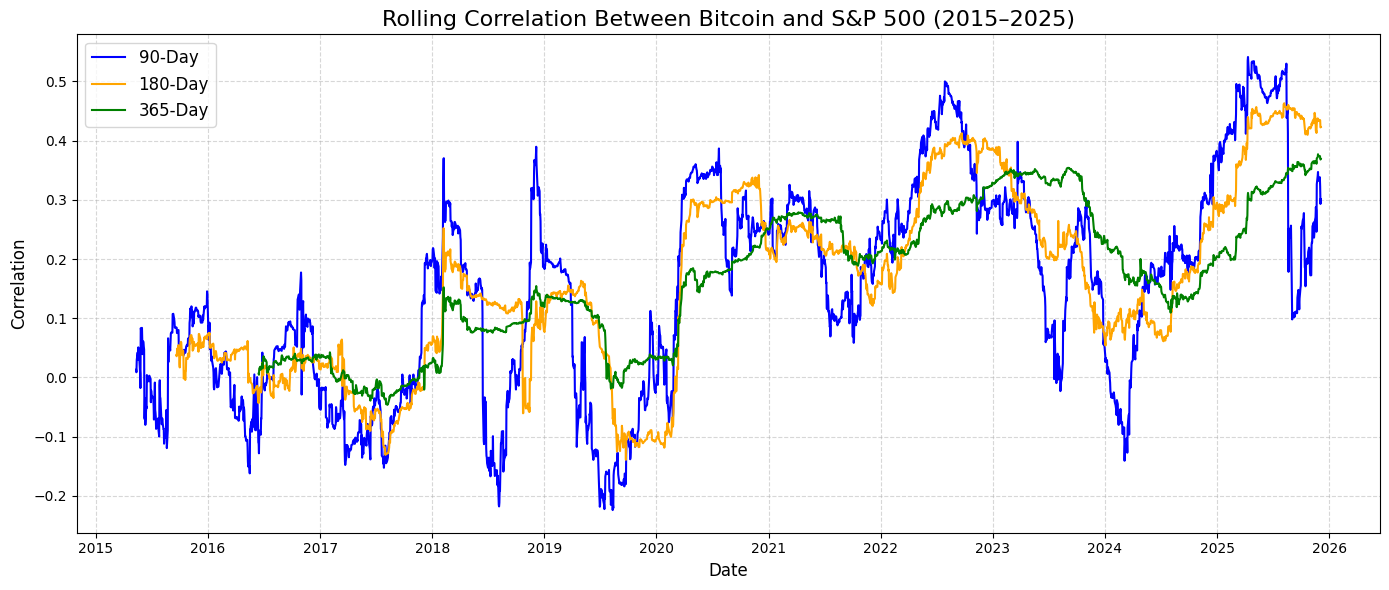

In [19]:
plt.figure(figsize=(14,6))

plt.plot(df['Date'], df['corr_90d'], label='90-Day', color='blue', linewidth=1.5)
plt.plot(df['Date'], df['corr_180d'], label='180-Day', color='orange', linewidth=1.5)
plt.plot(df['Date'], df['corr_365d'], label='365-Day', color='green', linewidth=1.5)

plt.title("Rolling Correlation Between Bitcoin and S&P 500 (2015–2025)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()




**Figure 4 – Comparison of 90-, 180-, and 365-Day Rolling Correlations**

This combined plot overlays the 90-day, 180-day, and 365-day rolling correlations on a single graph. The 90-day line captures short-term swings and reacts quickly to market shocks, while the 180-day and 365-day lines provide progressively smoother views of the medium- and long-run trends.

Taken together, the three lines show a consistent story: correlations are low and unstable in Bitcoin’s early years, then become more strongly and persistently positive after roughly 2018, with notable increases around the COVID-19 period and subsequent macroeconomic turmoil. The convergence of the longer windows in positive territory by the end of the sample supports the hypothesis that Bitcoin has become more “financialized” and more closely tied to equity-market conditions over time.


## Conclusion and Insights

The analysis conducted in this project reveals a clear evolution in the relationship between Bitcoin and the U.S. equity market over the period from 2015 to 2025. Using rolling correlations between the daily returns of Bitcoin (BTC-USD) and the S&P 500 index, I observe that Bitcoin initially behaved as an asset largely detached from traditional financial markets. In the early years of the sample, roughly 2015–2017, correlations across all window sizes (90-, 180-, and 365-day) were low, unstable, and frequently near zero. This pattern reflects Bitcoin’s early stage of development, during which it was primarily held by niche communities and was influenced by idiosyncratic technological and regulatory events rather than broad macroeconomic conditions.

Beginning around 2018, however, all correlation measures show a noticeable and sustained increase. This turning point corresponds with the period in which Bitcoin started to gain traction among institutional investors, exchanges matured, derivative markets expanded, and crypto assets became integrated into broader trading strategies. As traditional financial actors began treating Bitcoin more as a speculative risk asset than a technological experiment, its price movements became increasingly sensitive to global macroeconomic forces, investor sentiment, and liquidity conditions—factors that also shape equity markets.

The most notable increase in correlation occurs around the COVID-19 crisis in early 2020. During this period, the short-term 90-day rolling correlation rises sharply, reaching values around 0.4, as both Bitcoin and the S&P 500 reacted to the same global shock, monetary policy responses, and shifts in investor risk appetite. Although this pandemic-era surge is not the absolute peak of correlation over the full sample, it marks a clear turning point: after 2020, correlations no longer return to the near-zero levels observed in Bitcoin’s early years. Instead, the rolling correlations remain consistently elevated, and the long-term 365-day measure shows a sustained period of positive co-movement throughout the early 2020s. This persistence indicates that the increasing linkage between Bitcoin and the S&P 500 is not merely a temporary anomaly, but reflects a deeper structural integration of Bitcoin into broader financial market dynamics.

Taken together, these findings support the hypothesis that Bitcoin has become increasingly correlated with the U.S. stock market over time. Rather than serving as an independent hedge or safe-haven asset, Bitcoin now behaves more like a high-volatility speculative asset whose performance is heavily influenced by broader macroeconomic dynamics. This has important implications for portfolio diversification, risk management, and policy discussions about the systemic relevance of crypto assets.

---

## Limitations

While the results provide meaningful insights, several limitations should be noted. First, the analysis relies exclusively on daily closing prices, which may overlook intraday dynamics or rapid market movements that are especially common in cryptocurrency markets. Higher-frequency data could reveal more granular relationships between Bitcoin and equity markets.

Second, rolling correlations are inherently backward-looking and are sensitive to the choice of window size. Although I examine several windows (90, 180, 365 days), different choices (e.g., 30-day or 720-day windows) might reveal alternative patterns or different turning points in the evolution of the correlation.

Third, the analysis uses only one equity index (the S&P 500) as a benchmark for traditional financial markets. Bitcoin may behave differently relative to other asset classes, such as gold, emerging-market equities, bonds, or volatility indices. A multi-asset comparison could provide a more comprehensive picture of Bitcoin’s financial integration.

Fourth, correlation does not imply causation. While rising correlations suggest increased co-movement, they do not reveal the underlying mechanisms driving the relationship. Both assets may be responding to shared macroeconomic shocks, monetary policy, or liquidity conditions without directly influencing each other.

Finally, the sample period includes several extraordinary macroeconomic events—such as the COVID-19 crisis, rapid monetary tightening cycles, and shifts in market structure—which may distort long-term trends. Future data may show whether the elevated correlations observed in the 2020s persist, weaken, or reverse as market conditions change.

Despite these limitations, the analysis provides strong evidence that Bitcoin’s relationship with the U.S. stock market has evolved substantially over the last decade, offering a foundation for deeper future research on crypto–equity market integration.
